<a href="https://colab.research.google.com/github/micheusch/sagemaker/blob/main/binary_classifier_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

In [5]:
!pip install -U xlrd
df = pd.read_excel(open('default of credit card clients.xls' ,'rb'), header =1, index_col=0)

In [62]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=69)

In [103]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
EPOCHS = 20
HIDDEN_STATES = 20
FEATURES = X.shape[1]
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [104]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.values))
valid_data = TrainData(torch.FloatTensor(X_valid), 
                       torch.FloatTensor(y_valid.values))

In [105]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [111]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(FEATURES, HIDDEN_STATES) 
        self.layer_2 = nn.Linear(HIDDEN_STATES, HIDDEN_STATES)
        self.layer_out = nn.Linear(HIDDEN_STATES, 1) 
        self.sig = nn.Sigmoid()
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(HIDDEN_STATES)
        self.batchnorm2 = nn.BatchNorm1d(HIDDEN_STATES)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        # x = self.sig(x)
        return x

In [112]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    model.train()
    losses = AverageMeter()

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_size = y_batch.size(0)

        optimizer.zero_grad()       
        y_pred = model(X_batch)        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        losses.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()

    return losses.avg
  
def valid_fn(valid_loader, model, criterion, optimizer, epoch, device):
    model.eval()
    losses = AverageMeter()
    preds = []

    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_size = y_batch.size(0)
        
        with torch.no_grad():
          y_pred = model(X_batch)        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        losses.update(loss.item(), batch_size)

        preds.append(y_pred.sigmoid().to('cpu').numpy())
      
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [113]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

from sklearn.metrics import accuracy_score

In [114]:
train_loss = []
valid_loss = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassification()
model.to(device)
# print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


for e in range(1, EPOCHS+1):

    # train
    avg_train_loss = train_fn(train_loader, model, criterion, optimizer, e, device)

    # eval
    avg_valid_loss, predictions = valid_fn(valid_loader, model, criterion, optimizer, e, device)
    
    train_loss.append(avg_train_loss)
    valid_loss.append(avg_valid_loss)

    acc = accuracy_score(np.round(predictions[:,0]), y_valid.values)
    print(f'Epoch {e+0:03}: | Loss: {avg_train_loss:.5f} | Val Loss: {avg_valid_loss:.5f} | Acc: {acc:.3f}')   

Epoch 001: | Loss: 0.59205 | Val Loss: 0.47463 | Acc: 0.700
Epoch 002: | Loss: 0.46614 | Val Loss: 0.44389 | Acc: 0.716
Epoch 003: | Loss: 0.45170 | Val Loss: 0.43929 | Acc: 0.710
Epoch 004: | Loss: 0.44624 | Val Loss: 0.43891 | Acc: 0.713
Epoch 005: | Loss: 0.44411 | Val Loss: 0.43726 | Acc: 0.717
Epoch 006: | Loss: 0.44107 | Val Loss: 0.43625 | Acc: 0.713
Epoch 007: | Loss: 0.44091 | Val Loss: 0.43509 | Acc: 0.712
Epoch 008: | Loss: 0.43723 | Val Loss: 0.43511 | Acc: 0.717
Epoch 009: | Loss: 0.43825 | Val Loss: 0.43415 | Acc: 0.717
Epoch 010: | Loss: 0.43616 | Val Loss: 0.43546 | Acc: 0.724
Epoch 011: | Loss: 0.43656 | Val Loss: 0.43462 | Acc: 0.717
Epoch 012: | Loss: 0.43377 | Val Loss: 0.43426 | Acc: 0.722
Epoch 013: | Loss: 0.43412 | Val Loss: 0.43378 | Acc: 0.718
Epoch 014: | Loss: 0.43254 | Val Loss: 0.43339 | Acc: 0.711
Epoch 015: | Loss: 0.43411 | Val Loss: 0.43393 | Acc: 0.713
Epoch 016: | Loss: 0.43342 | Val Loss: 0.43403 | Acc: 0.710
Epoch 017: | Loss: 0.43124 | Val Loss: 0

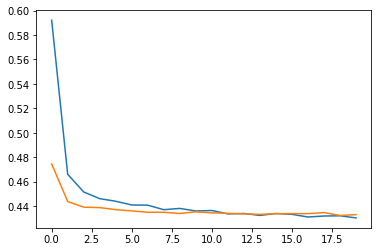

In [115]:
plt.plot(range(EPOCHS),train_loss)
plt.plot(range(EPOCHS),valid_loss);